In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/bureau.csv
/kaggle/input/home-credit-default-risk/application_train.csv


In [21]:
!pip install featuretools

In [22]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Read in the datasets and limit to the first 1000 rows (sorted by SK_ID_CURR) 
# This allows us to actually see the results in a reasonable amount of time! 
app_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:1000, :]
app_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:1000, :]
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True).loc[:1000, :]
bureau_balance = pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index(drop = True).loc[:1000, :]
cash = pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
credit = pd.read_csv('../input/home-credit-default-risk/credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
previous = pd.read_csv('../input/home-credit-default-risk/previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
installments = pd.read_csv('../input/home-credit-default-risk/installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]

We'll join the train and test set together but add a separate column identifying the set. This is important because we are going to want to apply the same exact procedures to each dataset. It's safest to just join them together and treat them as a single dataframe.

(I'm not sure if this is allowing data leakage into the train set and if these feature creation operations should be applied separately. Any thoughts would be much appreciated!)

In [24]:
# Add identifying column
app_train['set'] = 'train'
app_test['set'] = 'test'
app_test["TARGET"] = np.nan

# Append the dataframes
app = app_train.append(app_test, ignore_index = True)

In [25]:
# Entity set with id applications
es = ft.EntitySet(id = 'clients')

## Entities and Entitysets
An entity is simply a table or in Pandas, a dataframe. The observations are in the rows and the features in the columns. An entity in featuretools must have a unique index where none of the elements are duplicated. Currently, only app, bureau, and previous have unique indices (SK_ID_CURR, SK_ID_BUREAU, and SK_ID_PREV respectively). For the other dataframes, we must pass in make_index = True and then specify the name of the index. Entities can also have time indices where each entry is identified by a unique time. (There are not datetimes in any of the data, but there are relative times, given in months or days, that we could consider treating as time variables).

An EntitySet is a collection of tables and the relationships between them. This can be thought of a data structute with its own methods and attributes. Using an EntitySet allows us to group together multiple tables and manipulate them much quicker than individual tables.

First we'll make an empty entityset named clients to keep track of all the data.

Now we define each entity, or table of data. We need to pass in an index if the data has one or make_index = True if not. Featuretools will automatically infer the types of variables, but we can also change them if needed. For intstance, if we have a categorical variable that is represented as an integer we might want to let featuretools know the right type.

In [26]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app', dataframe = app, index = 'SK_ID_CURR')

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, index = 'SK_ID_PREV')

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bureaubalance_index')

es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index')

## Relationships
Relationships are a fundamental concept not only in featuretools, but in any relational database. The best way to think of a one-to-many relationship is with the analogy of parent-to-child. A parent is a single individual, but can have mutliple children. The children can then have multiple children of their own. In a parent table, each individual has a single row. Each individual in the parent table can have multiple rows in the child table.

As an example, the app dataframe has one row for each client (SK_ID_CURR) while the bureau dataframe has multiple previous loans (SK_ID_PREV) for each parent (SK_ID_CURR). Therefore, the bureau dataframe is the child of the app dataframe. The bureau dataframe in turn is the parent of bureau_balance because each loan has one row in bureau but multiple monthly records in bureau_balance.

In [27]:
print('Parent: app, Parent Variable: SK_ID_CURR\n\n', app.iloc[:, 111:115].head())
print('\nChild: bureau, Child Variable: SK_ID_CURR\n\n', bureau.iloc[10:30, :4].head())

Parent: app, Parent Variable: SK_ID_CURR

    FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20
0                 0                 0                 0                 0
1                 0                 0                 0                 0
2                 0                 0                 0                 0
3                 0                 0                 0                 0
4                 0                 0                 0                 0

Child: bureau, Child Variable: SK_ID_CURR

     SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY
10      100002       6158905        Closed      currency 1
11      100002       6158906        Closed      currency 1
12      100002       6158907        Closed      currency 1
13      100002       6158908        Closed      currency 1
14      100002       6158909        Active      currency 1


The SK_ID_CURR "100002" has one row in the parent table and multiple rows in the child.

Two tables are linked via a shared variable. The app and bureau dataframe are linked by the SK_ID_CURR variable while the bureau and bureau_balance dataframes are linked with the SK_ID_BUREAU. Defining the relationships is relatively straightforward, and the diagram provided by the competition is helpful for seeing the relationships. For each relationship, we need to specify the parent variable and the child variable. Altogether, there are a total of 6 relationships between the tables. Below we specify all six relationships and then add them to the EntitySet.

In [28]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es['app']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

In [29]:
# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  Entities:
    app [Rows: 2002, Columns: 123]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

Slightly advanced note: we need to be careful to not create a diamond graph where there are multiple paths from a parent to a child. If we directly link app and cash via SK_ID_CURR; previous and cash via SK_ID_PREV; and app and previous via SK_ID_CURR, then we have created two paths from app to cash. This results in ambiguity, so the approach we have to take instead is to link app to cash through previous. We establish a relationship between previous (the parent) and cash (the child) using SK_ID_PREV. Then we establish a relationship between app (the parent) and previous (now the child) using SK_ID_CURR. Then featuretools will be able to create features on app derived from both previous and cash by stacking multiple primitives.

All entities in the entity can be related to each other. In theory this allows us to calculate features for any of the entities, but in practice, we will only calculate features for the app dataframe since that will be used for training/testing.

## Feature premitive
Feature primitives fall into two categories:

Aggregation: function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum previous loan amount for each client. An aggregation works across multiple tables using relationships between tables.
Transformation: an operation applied to one or more columns in a single table. An example would be taking the absolute value of a column, or finding the difference between two columns in one table.
A list of the available features primitives in featuretools can be viewed below.

In [30]:
# List the primitives in a dataframe
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(10)

,name,type,dask_compatible,description
0,any,aggregation,True,Determines if any value is 'True' in a list.
1,time_since_first,aggregation,False,Calculates the time elapsed since the first datetime (in seconds).
2,percent_true,aggregation,True,Determines the percent of `True` values.
3,first,aggregation,False,Determines the first value in a list.
4,trend,aggregation,False,Calculates the trend of a variable over time.
5,skew,aggregation,False,Computes the extent to which a distribution differs from a normal distribution.
6,sum,aggregation,True,"Calculates the total addition, ignoring `NaN`."
7,avg_time_between,aggregation,False,Computes the average number of seconds between consecutive events.
8,num_true,aggregation,True,Counts the number of `True` values.
9,max,aggregation,True,"Calculates the highest value, ignoring `NaN` values."


In [31]:
primitives[primitives['type'] == 'transform'].head(10)

,name,type,dask_compatible,description
22,greater_than_equal_to,transform,True,Determines if values in one list are greater than or equal to another list.
23,longitude,transform,False,Returns the second tuple value in a list of LatLong tuples.
24,time_since_previous,transform,False,Compute the time since the previous entry in a list.
25,greater_than,transform,True,Determines if values in one list are greater than another list.
26,cum_max,transform,False,Calculates the cumulative maximum.
27,is_null,transform,True,Determines if a value is null.
28,not,transform,True,Negates a boolean value.
29,subtract_numeric,transform,True,Element-wise subtraction of two lists.
30,divide_numeric,transform,True,Element-wise division of two lists.
31,add_numeric,transform,True,Element-wise addition of two lists.


## Deep Feature synthesis
To perform DFS in featuretools, we use the dfs function passing it an entityset, the target_entity (where we want to make the features), the agg_primitives to use, the trans_primitives to use and the max_depth of the features. Here we will use the default aggregation and transformation primitives, a max depth of 2, and calculate primitives for the app entity. Because this process is computationally expensive, we can run the function using features_only = True to return only a list of the features and not calculate the features themselves. This can be useful to look at the resulting features before starting an extended computation.

In [36]:
# Default primitives from featuretools
default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine", "num_words", "num_characters"]

In [37]:
# DFS with default primitives
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app',
                                       trans_primitives = default_trans_primitives,
                                       agg_primitives=default_agg_primitives, 
                                        max_depth = 2, features_only=False, verbose = True)

pd.options.display.max_columns = 1700
feature_matrix.head(10)

Built 2221 features
Elapsed: 00:13 | Progress: 100%|██████████


TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002         1.0         Cash loans           M            N   
100003         0.0         Cash loans           F            N   
100004         0.0    Revolving loans           M            Y   
100006         0.0         Cash loans           F            N   
100007         0.0         Cash loans           M            N   
100008         0.0         Cash loans           M            N   
100009         0.0         Cash loans           F            Y   
100010         0.0         Cash loans           M            Y   
100011         0.0         Cash loans           F            N   
100012         0.0    Revolving loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
100008                   Y             0           99000.0    490495.5   
100009                   Y             1          171000.0   1560726.0   
100010                   Y             0          360000.0   1530000.0   
100011                   Y             0          112500.0   1019610.0   
100012                   Y             0          135000.0    405000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
SK_ID_CURR                                                  
100002          24700.5         351000.0    Unaccompanied   
100003          35698.5        1129500.0           Family   
100004           6750.0         135000.0    Unaccompanied   
100006          29686.5         297000.0    Unaccompanied   
100007          21865.5         513000.0    Unaccompanied   
100008          27517.5         454500.0  Spouse, partner   
100009          41301.0        1395000.0    Unaccompanied   
100010          42075.0        1530000.0    Unaccompanied   
100011          33826.5         913500.0         Children   
100012          20250.0         405000.0    Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
100008             State servant  Secondary / secondary special   
100009      Commercial associate               Higher education   
100010             State servant               Higher education   
100011                 Pensioner  Secondary / secondary special   
100012                   Working  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
100008                   Married  House / apartment   
100009                   Married  House / apartment   
100010                   Married  House / apartment   
100011                   Married  House / apartment   
100012      Single / not married  House / apartment   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                    

In [38]:
feature_names[-20:]

[<Feature: NUM_UNIQUE(credit.previous.NAME_CLIENT_TYPE)>,
 <Feature: NUM_UNIQUE(credit.previous.WEEKDAY_APPR_PROCESS_START)>,
 <Feature: NUM_UNIQUE(credit.previous.NAME_TYPE_SUITE)>,
 <Feature: MODE(credit.previous.PRODUCT_COMBINATION)>,
 <Feature: MODE(credit.previous.FLAG_LAST_APPL_PER_CONTRACT)>,
 <Feature: MODE(credit.previous.NAME_GOODS_CATEGORY)>,
 <Feature: MODE(credit.previous.CHANNEL_TYPE)>,
 <Feature: MODE(credit.previous.NAME_CASH_LOAN_PURPOSE)>,
 <Feature: MODE(credit.previous.NAME_CONTRACT_TYPE)>,
 <Feature: MODE(credit.previous.NAME_SELLER_INDUSTRY)>,
 <Feature: MODE(credit.previous.NAME_CONTRACT_STATUS)>,
 <Feature: MODE(credit.previous.NAME_YIELD_GROUP)>,
 <Feature: MODE(credit.previous.SK_ID_CURR)>,
 <Feature: MODE(credit.previous.CODE_REJECT_REASON)>,
 <Feature: MODE(credit.previous.NAME_PAYMENT_TYPE)>,
 <Feature: MODE(credit.previous.NAME_PORTFOLIO)>,
 <Feature: MODE(credit.previous.NAME_PRODUCT_TYPE)>,
 <Feature: MODE(credit.previous.NAME_CLIENT_TYPE)>,
 <Feature: M

In [39]:
# Specify the aggregation primitives
feature_matrix_spec, feature_names_spec = ft.dfs(entityset = es, target_entity = 'app',  
                                                 agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode'], 
                                                 max_depth = 2, features_only = False, verbose = True)

Built 1215 features
Elapsed: 00:04 | Progress: 100%|██████████


In [40]:
pd.options.display.max_columns = 1000
feature_matrix_spec.head(10)

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002         1.0         Cash loans           M            N   
100003         0.0         Cash loans           F            N   
100004         0.0    Revolving loans           M            Y   
100006         0.0         Cash loans           F            N   
100007         0.0         Cash loans           M            N   
100008         0.0         Cash loans           M            N   
100009         0.0         Cash loans           F            Y   
100010         0.0         Cash loans           M            Y   
100011         0.0         Cash loans           F            N   
100012         0.0    Revolving loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
100008                   Y             0           99000.0    490495.5   
100009                   Y             1          171000.0   1560726.0   
100010                   Y             0          360000.0   1530000.0   
100011                   Y             0          112500.0   1019610.0   
100012                   Y             0          135000.0    405000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
SK_ID_CURR                                                  
100002          24700.5         351000.0    Unaccompanied   
100003          35698.5        1129500.0           Family   
100004           6750.0         135000.0    Unaccompanied   
100006          29686.5         297000.0    Unaccompanied   
100007          21865.5         513000.0    Unaccompanied   
100008          27517.5         454500.0  Spouse, partner   
100009          41301.0        1395000.0    Unaccompanied   
100010          42075.0        1530000.0    Unaccompanied   
100011          33826.5         913500.0         Children   
100012          20250.0         405000.0    Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
100008             State servant  Secondary / secondary special   
100009      Commercial associate               Higher education   
100010             State servant               Higher education   
100011                 Pensioner  Secondary / secondary special   
100012                   Working  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
100008                   Married  House / apartment   
100009                   Married  House / apartment   
100010                   Married  House / apartment   
100011                   Married  House / apartment   
100012      Single / not married  House / apartment   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                    

## Correlations
Next we can look at correlations within the data. When we look at correlations with the target, we need to be careful about the multiple comparisons problem: if we make a ton of features, some are likely to be correlated with the target simply because of random noise. Using correlations is fine as a first approximation for identifying "good features", but it is not a rigorous feature selection method.

Also, based on examining some of the features, it seems there might be issues with collinearity between features made by featuretools. Features that are highly correlated with one another can diminish interpretability and generalization performance on the test set. In an ideal scenario, we would have a set of independent features, but that rarely occurs in practice. If there are very highly correlated varibables, we might want to think about removing some of them.

For the correlations, we will focus on the feature_matrix_spec, the features we made by specifying the primitives. The same analysis could be applied to the default feature set. These correlations were calculated using the entire training section of the feature matrix.

In [42]:
correlations = pd.read_csv('../input/home-credit-default-risk-feature-tools/correlations_spec.csv', index_col = 0)
correlations.index.name = 'Variable'
correlations.head()

,SK_ID_CURR,FLAG_EMP_PHONE,DEF_60_CNT_SOCIAL_CIRCLE,LIVE_REGION_NOT_WORK_REGION,YEARS_BEGINEXPLUATATION_AVG,APARTMENTS_MODE,FLAG_MOBIL,FLOORSMIN_MEDI,BASEMENTAREA_AVG,LANDAREA_MODE,FLAG_DOCUMENT_21,AMT_GOODS_PRICE,COMMONAREA_MODE,APARTMENTS_MEDI,EXT_SOURCE_1,EXT_SOURCE_3,FLAG_DOCUMENT_16,LIVINGAPARTMENTS_MODE,ENTRANCES_MEDI,YEARS_BEGINEXPLUATATION_MODE,APARTMENTS_AVG,FLAG_DOCUMENT_12,FLAG_DOCUMENT_5,DAYS_LAST_PHONE_CHANGE,ELEVATORS_MODE,BASEMENTAREA_MODE,FLAG_DOCUMENT_13,FLAG_DOCUMENT_3,REGION_RATING_CLIENT,FLAG_DOCUMENT_6,AMT_REQ_CREDIT_BUREAU_DAY,COMMONAREA_AVG,DAYS_BIRTH,FLAG_DOCUMENT_14,FLOORSMAX_MEDI,OBS_30_CNT_SOCIAL_CIRCLE,YEARS_BEGINEXPLUATATION_MEDI,CNT_FAM_MEMBERS,FLOORSMAX_MODE,YEARS_BUILD_AVG,ENTRANCES_AVG,FLAG_DOCUMENT_10,ENTRANCES_MODE,DAYS_ID_PUBLISH,REGION_POPULATION_RELATIVE,FLAG_DOCUMENT_18,FLAG_DOCUMENT_7,FLAG_DOCUMENT_11,OBS_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_15,COMMONAREA_MEDI,FLAG_PHONE,DAYS_REGISTRATION,REGION_RATING_CLIENT_W_CITY,NONLIVINGAREA_MEDI,YEARS_BUILD_MODE,AMT_CREDIT,LIVINGAPARTMENTS_MEDI,FLOORSMIN_MODE,EXT_SOURCE_2,HOUR_APPR_PROCESS_START,FLOORSMIN_AVG,YEARS_BUILD_MEDI,OWN_CAR_AGE,FLAG_CONT_MOBILE,FLAG_DOCUMENT_2,REG_REGION_NOT_LIVE_REGION,DEF_30_CNT_SOCIAL_CIRCLE,NONLIVINGAREA_MODE,REG_CITY_NOT_WORK_CITY,DAYS_EMPLOYED,LIVINGAREA_MEDI,FLAG_DOCUMENT_4,ELEVATORS_MEDI,FLAG_DOCUMENT_8,LIVINGAPARTMENTS_AVG,FLAG_DOCUMENT_9,LIVINGAREA_AVG,AMT_REQ_CREDIT_BUREAU_HOUR,FLAG_DOCUMENT_17,NONLIVINGAPARTMENTS_MEDI,CNT_CHILDREN,FLAG_WORK_PHONE,FLAG_DOCUMENT_19,REG_CITY_NOT_LIVE_CITY,NONLIVINGAPARTMENTS_AVG,AMT_INCOME_TOTAL,BASEMENTAREA_MEDI,AMT_REQ_CREDIT_BUREAU_QRT,LANDAREA_AVG,TARGET,LANDAREA_MEDI,TOTALAREA_MODE,AMT_ANNUITY,NONLIVINGAREA_AVG,ELEVATORS_AVG,NONLIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,FLAG_EMAIL,FLOORSMAX_AVG,REG_REGION_NOT_WORK_REGION,LIVE_CITY_NOT_WORK_CITY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_MON,FLAG_DOCUMENT_20,MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT),MIN(credit.MONTHS_BALANCE),MAX(credit.AMT_RECEIVABLE_PRINCIPAL),SUM(credit.AMT_DRAWINGS_OTHER_CURRENT),MAX(bureau.AMT_ANNUITY),SUM(previous_app.DAYS_FIRST_DUE),SUM(bureau_balance.MONTHS_BALANCE),SUM(previous_app.DAYS_TERMINATION),COUNT(bureau),MAX(credit.SK_DPD_DEF),SUM(previous_app.AMT_DOWN_PAYMENT),MAX(bureau.DAYS_CREDIT_ENDDATE),SUM(bureau.DAYS_ENDDATE_FACT),MAX(previous_app.CNT_PAYMENT),MIN(bureau.AMT_CREDIT_SUM_OVERDUE),MAX(bureau.CREDIT_DAY_OVERDUE),MEAN(credit.AMT_DRAWINGS_OTHER_CURRENT),MIN(credit.AMT_PAYMENT_TOTAL_CURRENT),MAX(credit.AMT_INST_MIN_REGULARITY),MAX(previous_app.AMT_GOODS_PRICE),MEAN(previous_app.AMT_ANNUITY),MAX(credit.AMT_PAYMENT_TOTAL_CURRENT),MAX(bureau.DAYS_CREDIT_UPDATE),SUM(bureau.AMT_CREDIT_SUM_LIMIT),SUM(previous_app.DAYS_FIRST_DRAWING),MAX(bureau.AMT_CREDIT_SUM),MEAN(bureau.AMT_CREDIT_SUM_DEBT),MIN(previous_app.DAYS_FIRST_DRAWING),MAX(previous_app.DAYS_DECISION),MIN(previous_app.DAYS_FIRST_DUE),MAX(credit.SK_DPD),MEAN(previous_app.AMT_GOODS_PRICE),MIN(cash.SK_DPD_DEF),MIN(bureau.DAYS_ENDDATE_FACT),MEAN(cash.SK_ID_CURR),SUM(credit.AMT_BALANCE),MEAN(bureau.CREDIT_DAY_OVERDUE),MEAN(installments.NUM_INSTALMENT_VERSION),MEAN(installments.NUM_INSTALMENT_NUMBER),MEAN(previous_app.RATE_DOWN_PAYMENT),MEAN(bureau.AMT_CREDIT_SUM_OVERDUE),SUM(bureau.CNT_CREDIT_PROLONG),MIN(previous_app.DAYS_DECISION),MIN(cash.SK_ID_CURR),SUM(credit.AMT_PAYMENT_CURRENT),MEAN(credit.AMT_BALANCE),MIN(bureau.CNT_CREDIT_PROLONG),MAX(credit.AMT_DRAWINGS_ATM_CURRENT),MIN(installments.AMT_INSTALMENT),MAX(credit.AMT_TOTAL_RECEIVABLE),SUM(cash.CNT_INSTALMENT),MAX(previous_app.RATE_INTEREST_PRIMARY),MEAN(bureau.DAYS_CREDIT_ENDDATE),MEAN(credit.SK_ID_CURR),MEAN(previous_app.DAYS_FIRST_DUE),COUNT(cash),MEAN(previous_app.DAYS_DECISION),MEAN(previous_app.DAYS_FIRST_DRAWING),MEAN(bureau.DAYS_ENDDATE_FACT),MAX(installments.AMT_PAYMENT),MAX(previous_app.AMT_ANNUITY),SUM(bureau.AMT_ANNUITY),MAX(previous_app.DAYS_FIRST_DRAWING),MAX(cash.CNT_INSTALMENT_FUTURE),MEAN(previous_app.NFLAG_LAST_APPL_IN_DAY),MAX(previous_app.HOUR_AP

In [43]:
correlations_target = correlations.sort_values('TARGET')['TARGET']
# Most negative correlations
correlations_target.head()

Variable
EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
MODE(bureau.CREDIT_ACTIVE)_Closed      -0.070201
NAME_EDUCATION_TYPE_Higher education   -0.056593
Name: TARGET, dtype: float64

In [44]:
# Most positive correlations
correlations_target.dropna().tail()

Variable
MIN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.102765
MEAN(credit.CNT_DRAWINGS_ATM_CURRENT)                       0.102774
MEAN(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))    0.102917
MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))     0.102996
TARGET                                                      1.000000
Name: TARGET, dtype: float64

In [45]:
features_sample = pd.read_csv('../input/home-credit-default-risk-feature-tools/feature_matrix.csv', nrows = 20000)
features_sample = features_sample[features_sample['set'] == 'train']
features_sample.head()

,SK_ID_CURR,NAME_TYPE_SUITE,REG_REGION_NOT_LIVE_REGION,EXT_SOURCE_2,OCCUPATION_TYPE,FLAG_PHONE,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_RATING_CLIENT,REG_REGION_NOT_WORK_REGION,CNT_FAM_MEMBERS,DAYS_BIRTH,REG_CITY_NOT_LIVE_CITY,COMMONAREA_AVG,FLAG_WORK_PHONE,HOUSETYPE_MODE,FLAG_DOCUMENT_21,ELEVATORS_AVG,LIVINGAPARTMENTS_MODE,set,FLOORSMAX_MODE,FLAG_DOCUMENT_17,AMT_REQ_CREDIT_BUREAU_QRT,COMMONAREA_MEDI,FLAG_EMAIL,FLAG_DOCUMENT_5,ORGANIZATION_TYPE,FLAG_OWN_REALTY,DAYS_REGISTRATION,DAYS_ID_PUBLISH,LANDAREA_MODE,NONLIVINGAPARTMENTS_MEDI,FLAG_DOCUMENT_15,REGION_POPULATION_RELATIVE,LIVE_REGION_NOT_WORK_REGION,LIVINGAREA_MEDI,FLOORSMIN_MODE,ELEVATORS_MEDI,NAME_INCOME_TYPE,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_EMP_PHONE,FLAG_DOCUMENT_13,LIVINGAPARTMENTS_MEDI,DEF_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_3,FLAG_DOCUMENT_8,FLAG_OWN_CAR,LANDAREA_MEDI,FLAG_DOCUMENT_18,FONDKAPREMONT_MODE,TOTALAREA_MODE,NAME_CONTRACT_TYPE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_HOUR,FLAG_DOCUMENT_12,NAME_FAMILY_STATUS,ENTRANCES_MEDI,BASEMENTAREA_AVG,CNT_CHILDREN,FLAG_DOCUMENT_6,DAYS_LAST_PHONE_CHANGE,CODE_GENDER,YEARS_BUILD_MEDI,AMT_REQ_CREDIT_BUREAU_WEEK,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_7,ELEVATORS_MODE,FLOORSMIN_AVG,HOUR_APPR_PROCESS_START,YEARS_BUILD_AVG,FLAG_CONT_MOBILE,NONLIVINGAPARTMENTS_AVG,APARTMENTS_MEDI,BASEMENTAREA_MODE,LIVINGAPARTMENTS_AVG,EXT_SOURCE_1,YEARS_BUILD_MODE,ENTRANCES_AVG,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,FLAG_DOCUMENT_10,AMT_REQ_CREDIT_BUREAU_DAY,FLAG_DOCUMENT_4,FLAG_DOCUMENT_20,FLOORSMIN_MEDI,FLAG_DOCUMENT_11,BASEMENTAREA_MEDI,WEEKDAY_APPR_PROCESS_START,FLAG_DOCUMENT_3,OBS_60_CNT_SOCIAL_CIRCLE,YEARS_BEGINEXPLUATATION_MEDI,NAME_HOUSING_TYPE,LIVINGAREA_AVG,AMT_GOODS_PRICE,REG_CITY_NOT_WORK_CITY,FLAG_MOBIL,DAYS_EMPLOYED,FLAG_DOCUMENT_2,FLAG_DOCUMENT_9,LIVINGAREA_MODE,NONLIVINGAREA_MEDI,LANDAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,YEARS_BEGINEXPLUATATION_AVG,NONLIVINGAREA_AVG,TARGET,AMT_ANNUITY,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLAG_DOCUMENT_19,APARTMENTS_MODE,FLOORSMAX_MEDI,ENTRANCES_MODE,APARTMENTS_AVG,REGION_RATING_CLIENT_W_CITY,WALLSMATERIAL_MODE,NAME_EDUCATION_TYPE,FLAG_DOCUMENT_14,COMMONAREA_MODE,OWN_CAR_AGE,FLAG_DOCUMENT_16,NUM_UNIQUE(previous_app.NAME_CASH_LOAN_PURPOSE),MAX(credit.CNT_INSTALMENT_MATURE_CUM),MEAN(credit.AMT_DRAWINGS_POS_CURRENT),MIN(credit.AMT_TOTAL_RECEIVABLE),MAX(cash.SK_DPD),STD(credit.SK_DPD),MAX(bureau.CREDIT_DAY_OVERDUE),MEAN(credit.AMT_INST_MIN_REGULARITY),NUM_UNIQUE(cash.NAME_CONTRACT_STATUS),MAX(previous_app.DAYS_TERMINATION),MEAN(previous_app.AMT_DOWN_PAYMENT),SKEW(credit.AMT_CREDIT_LIMIT_ACTUAL),MAX(bureau.DAYS_CREDIT_ENDDATE),NUM_UNIQUE(bureau.CREDIT_ACTIVE),SUM(bureau.AMT_CREDIT_SUM),STD(bureau.DAYS_CREDIT),SUM(cash.SK_DPD),MIN(cash.CNT_INSTALMENT),MEAN(cash.CNT_INSTALMENT),STD(previous_app.AMT_CREDIT),MAX(installments.AMT_INSTALMENT),SUM(previous_app.DAYS_FIRST_DRAWING),SUM(credit.CNT_DRAWINGS_ATM_CURRENT),MODE(previous_app.NAME_CONTRACT_TYPE),MEAN(credit.AMT_RECIVABLE),MODE(bureau_balance.STATUS),COUNT(bureau_balance),MIN(bureau.AMT_CREDIT_SUM_DEBT),MODE(bureau.CREDIT_CURRENCY),STD(installments.NUM_INSTALMENT_VERSION),MIN(bureau.DAYS_CREDIT_UPDATE),MEAN(installments.DAYS_INSTALMENT),NUM_UNIQUE(previous_app.NAME_CONTRACT_TYPE),MEAN(bureau.AMT_CREDIT_SUM),SKEW(bureau.CREDIT_DAY_OVERDUE),SKEW(credit.CNT_DRAWINGS_POS_CURRENT),SKEW(installments.DAYS_ENTRY_PAYMENT),MIN(previous_app.NFLAG_LAST_APPL_IN_DAY),MIN(previous_app.RATE_INTEREST_PRIMARY),SKEW(cash.SK_DPD_DEF),SUM(credit.AMT_DRAWINGS_CURRENT),MAX(credit.CNT_DRAWINGS_CURRENT),MEAN(previous_app.SELLERPLACE_AREA),SUM(credit.CNT_INSTALMENT_MATURE_CUM),MODE(previous_app.NAME_GOODS_CATEGORY),MAX(cash.SK_DPD_DEF),MEAN(cash.MONTHS_BALANCE),MEAN(bureau.AMT_CREDIT_SUM_LIMIT),MAX(bureau.DAYS_CREDIT_UPDATE),NUM_UNIQUE(previous_app.NAME_GOODS_CATEGORY),MODE(bureau.CREDIT_ACTIVE),SUM(credit.AMT_PAYMENT_CURRENT),MEAN(bureau.CREDIT_DAY_OVERDUE),MEAN(credit.AMT_DRAWINGS_CURRENT),SKEW(credit.AMT_RECEIVABLE_PRINCIPAL),MA

In [46]:
def kde_target_plot(df, feature):
    """Kernel density estimate plot of a feature colored
    by value of the target."""
    
    # Need to reset index for loc to workBU
    df = df.reset_index()
    plt.figure(figsize = (10, 6))
    plt.style.use('fivethirtyeight')
    
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of Feature by Target Value')
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.show()

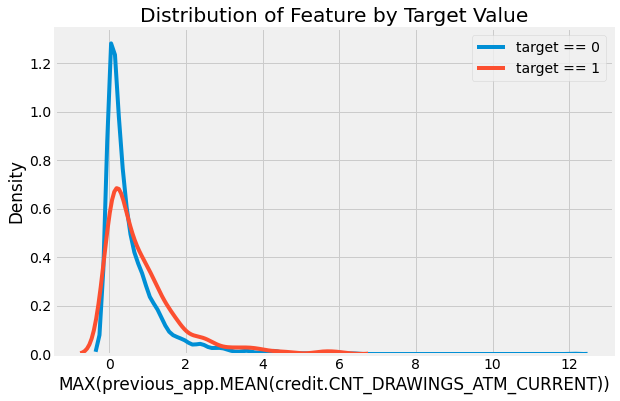

In [47]:
kde_target_plot(features_sample, feature = 'MAX(previous_app.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))')

In [48]:
threshold = 0.9

correlated_pairs = {}

# Iterate through the columns
for col in correlations:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(correlations.index[correlations[col] > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

In [49]:
correlated_pairs['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)']

['MEAN(credit.AMT_PAYMENT_CURRENT)',
 'MIN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MEAN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'SUM(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MIN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MEAN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MAX(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MAX(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'SUM(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))']

In [50]:
correlations['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)'].sort_values(ascending=False).head()

Variable
MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)                       1.000000
MEAN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))    0.999382
MIN(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.999024
MAX(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.995957
SUM(previous_app.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     0.995484
Name: MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT), dtype: float64

In [ ]:
plt.plot(features_sample['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)'], features_sample['MEAN(previous_app.MEAN(credit.AMT_PAYMENT_CURRENT))'], 'bo')
plt.title('Highly Correlated Features');